# Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Agents

## Doctor

In [2]:
class Doctor:
    
    
    def __init__(self, doctor_id, num_doctors, num_patients, rating_manager):
        self.doctor_id = doctor_id
        self.rating_manager = rating_manager
        self.experience = 0  # Initialize experience to zero
        self.research_ability = random.uniform(0.2,0.6)  # Initial random value for research ability
        self.empathy = random.uniform(0.2,0.7)  # Initial random value for empathy
        self.personal_resource_constraint = 0.8  # Personal constraint on ability development
        self.personal_resource = 1 - self.personal_resource_constraint  # Personal resource for ability development 
        self.technological_resource_constraint = random.uniform(0.2,0.5)  # External constraint, affects treatment effectiveness
        self.credential = random.choice(['low', 'medium', 'high'])  # Random initial credential
        self.is_busy = False  # Doctor is not busy initially
        
        # Initialize social ties with other doctors, excluding self
        self.social_ties_doctors = {i: random.random() for i in range(num_doctors) if i != doctor_id}
        # Initialize social ties with all patients
        self.social_ties_patients = {i: random.random() for i in range(num_patients)}
        
        self.respect_for_colleagues = {i: 0 for i in range(num_doctors) if i != doctor_id}  # Initialize respect as zero for each other doctor
        
        self.confidence = 0  # Initial confidence level
        
        self.weight_wmrat = 0.5 # Weight for mean weighted ratings
        self.weight_mwres = 0.5 # Weight for mean weighted respects
        
    
    def start_treatment(self):
        self.is_busy = True
        
    
    def end_treatment(self):
        self.is_busy = False

    
    def treat_patient(self, all_doctors):
        """Calculate the treatment effectiveness first before updating the doctor's experience and abilities."""
        if self.is_busy:
            return 0
        self.start_treatment()
        effectiveness = self.calculate_treatment_effectiveness()
        self.update_experience_and_abilities()  # Now update experience and abilities
        self.update_confidence(self.rating_manager, all_doctors)
        # self.end_treatment()
        return effectiveness
    
    
    def update_experience_and_abilities(self):
        """Update the doctor's experience and abilities after treating a patient."""
        self.experience += 1
        self.upgrade_credential()
            

    def upgrade_credential(self):
        """Upgrade credentials based on experience and research ability."""
        if self.credential == 'low' and (self.research_ability >= 0.5 and self.experience >= 50):
            self.credential = 'medium'
        elif self.credential == 'medium' and (self.research_ability >= 0.8 and self.experience >=80):
            self.credential = 'high'
            
    
    def calculate_treatment_effectiveness(self):
        """Calculate treatment effectiveness based on credential, empathy, and technological resource constraint."""
        credential_factor = {'low': 0.1, 'medium': 0.2, 'high': 0.3}
        effectiveness = (credential_factor[self.credential] + self.empathy + self.confidence) * (1 - self.technological_resource_constraint)
        return min(effectiveness, 0.7)
    
    
    def calculate_mean_weighted_respects(self, all_doctors):
        """Calculate mean weighted respects from colleagues directed towards Doctor i."""
        total_weighted_respects = 0
        total_social_strengths = 0

        for doctor in all_doctors:
            if doctor.doctor_id != self.doctor_id:
                respect_from_other_doctor = doctor.respect_for_colleagues.get(self.doctor_id, 0)
                social_strength_to_other_doctor = self.social_ties_doctors.get(doctor.doctor_id, 0)

                if social_strength_to_other_doctor > 0:
                    total_weighted_respects += respect_from_other_doctor * social_strength_to_other_doctor
                    total_social_strengths += social_strength_to_other_doctor

        return total_weighted_respects / total_social_strengths if total_social_strengths > 0 else 0

       
    def update_respect_for_colleagues(self, all_doctors, rating_manager):
        """Update respect for all other doctors based on credentials and weighted ratings from patients."""
        for other_doctor in all_doctors:
            if self.doctor_id != other_doctor.get_id():
                # Calculate weighted valuation
                weighted_valuation = rating_manager.get_weighted_valuation(other_doctor.get_id(), self.social_ties_patients)
                
                # Get credential score
                credential_factor = {'low': 0.1, 'medium': 0.5, 'high': 0.8}
                credential_score = credential_factor[other_doctor.get_credential()]
                
                # Total valuation includes credential score and weighted valuation
                total_valuation = credential_score + weighted_valuation
                
                # Multiply by social strength for doctor j
                social_strength = self.social_ties_doctors.get(other_doctor.get_id(), 0)
                self.respect_for_colleagues[other_doctor.get_id()] = social_strength * total_valuation
    

    def update_confidence(self, rating_manager, all_doctors):
        """Update the doctor's confidence based on weighted ratings and respects."""
        mean_weighted_ratings = rating_manager.calculate_mean_weighted_ratings(self.doctor_id, self.social_ties_patients)
        mean_weighted_respects = self.calculate_mean_weighted_respects(all_doctors)
        self.confidence = self.weight_wmrat * mean_weighted_ratings + self.weight_mwres * mean_weighted_respects
    
    
    def get_experience(self):
        return self.experience
    
    
    def get_id(self):
        return self.doctor_id


    def get_research_ability(self):
        return self.research_ability


    def get_empathy(self):
        return self.empathy


    def get_personal_resource_constraint(self):
        return self.personal_resource_constraint


    def get_technological_resource_constraint(self):
        return self.technological_resource_constraint


    def get_credential(self):
        return self.credential
    
    
    def get_social_ties_doctors(self):
        """Retrieve the doctor's social ties with other doctors."""
        return self.social_ties_doctors


    def get_social_ties_patients(self):
        """Retrieve the doctor's social ties with patients."""
        return self.social_ties_patients
    
    
    
    

# Codes for implementing the genetic algorithm
    
    def mutate(self):
        # Retrieve recent feedback to decide on the mutation strength
        recent_feedback = self.rating_manager.get_recent_feedback(self.doctor_id)
        mutation_factor = 1.5 if recent_feedback < 3 else 0.5  # Adjust the mutation strength based on feedback

        # Calculate the potential mutation amount
        mutation_amount = random.uniform(0, 0.05) * mutation_factor

        # Select which trait to mutate
        trait_to_mutate = random.random()

        # Mutation logic for each trait
        if trait_to_mutate < 0.2 and self.personal_resource > 0:  # 20% chance to mutate research_ability
            change = mutation_amount * random.choice([-1, 1])
            if 0 <= self.research_ability + change <= 1:  # Check bounds before applying mutation
                actual_change = min(abs(change), self.personal_resource)  # Limit change by available resources
                self.research_ability += actual_change * (1 if change > 0 else -1)
                self.personal_resource -= actual_change
        elif trait_to_mutate < 0.4 and self.personal_resource > 0:  # 20% chance to mutate empathy
            change = mutation_amount * random.choice([-1, 1])
            if 0 <= self.empathy + change <= 1:  # Check bounds before applying mutation
                actual_change = min(abs(change), self.personal_resource)  # Limit change by available resources
                self.empathy += actual_change * (1 if change > 0 else -1)
                self.personal_resource -= actual_change
        elif trait_to_mutate < 0.6:  # 20% chance to mutate weight for mean weighted rating
            change = mutation_amount * random.choice([-1, 1])
            self.weight_wmrat += change
            self.weight_wmrat = max(0, min(1, self.weight_wmrat))
        elif trait_to_mutate < 0.8:  # 20% chance to mutate weight for mean weighted respects
            change = mutation_amount * random.choice([-1, 1])
            self.weight_mwres += change
            self.weight_mwres = max(0, min(1, self.weight_mwres))
        else:  # 20% chance to mutate social ties
            # Randomly choose a doctor or patient to mutate social ties with
            if random.random() < 0.5 and self.social_ties_doctors:
                random_doc_id = random.choice(list(self.social_ties_doctors.keys()))
                change = mutation_amount * random.choice([-1, 1])
                self.social_ties_doctors[random_doc_id] += change
                self.social_ties_doctors[random_doc_id] = max(0, min(1, self.social_ties_doctors[random_doc_id]))
            elif self.social_ties_patients:
                random_patient_id = random.choice(list(self.social_ties_patients.keys()))
                change = mutation_amount * random.choice([-1, 1])
                self.social_ties_patients[random_patient_id] += change
                self.social_ties_patients[random_patient_id] = max(0, min(1, self.social_ties_patients[random_patient_id]))

        # Ensure personal resources do not drop below zero
        self.personal_resource = max(0, self.personal_resource)

    
    def calculate_fitness(self):
        """Calculate fitness based on multiple factors."""
        # Main component: Mean weighted rating from patients
        base_fitness = self.rating_manager.get_mean_rating(self.doctor_id) if self.rating_manager else 0
        
        # Additional components: Weigh contributions from research ability and empathy
        # You can adjust these weights to balance their impact on the overall fitness
        # For instance, 0.1 for research ability and 0.05 for empathy
        research_contribution = 0.1 * self.research_ability
        empathy_contribution = 0.05 * self.empathy

        # Calculate total fitness
        total_fitness = base_fitness 
        # + research_contribution + empathy_contribution

        return total_fitness

    
    def crossover(self, other):
        """Performs crossover between this doctor and another doctor."""
        if random.random() < 0.5:  # Optionally perform crossover with a 50% chance
            # Simple averaging crossover for research_ability and empathy
            self.research_ability = (self.research_ability + other.research_ability) / 2
            self.empathy = (self.empathy + other.empathy) / 2

            # Also perform crossover for weights
            self.weight_wmrat = (self.weight_wmrat + other.weight_wmrat) / 2
            self.weight_mwres = (self.weight_mwres + other.weight_mwres) / 2

            # Crossover for a selected set of social ties with doctors
            # Randomly pick some social ties to average
            for key in self.social_ties_doctors.keys():
                if key in other.social_ties_doctors:  # Ensure both doctors have the social tie
                    self.social_ties_doctors[key] = (self.social_ties_doctors[key] + other.social_ties_doctors[key]) / 2
            
            # Similar approach for patient social ties if implemented
            for key in self.social_ties_patients.keys():
                if key in other.social_ties_patients:  # Ensure both doctors have the social tie
                    self.social_ties_patients[key] = (self.social_ties_patients[key] + other.social_ties_patients[key]) / 2


    def log_status(self):
        """Logs the current status of the doctor for debugging and analysis purposes."""
        print(f"Doctor {self.doctor_id}: Experience = {self.experience}, "
            f"Research Ability = {self.research_ability:.2f}, "
            f"Empathy = {self.empathy:.2f}, "
            f"Credential = {self.credential}, "
            f"Personal Resource Constraint = {self.personal_resource_constraint:.2f}, "
            f"Technological Resource Constraint = {self.technological_resource_constraint:.2f}, "
            f"Weight for Mean Weighted Rating = {self.weight_wmrat:.2f}, "
            f"Weight for Mean Weighted Respect = {self.weight_mwres:.2f}, "
            f"Confidence = {self.confidence:.2f}")

        # Optionally, log some details about social ties to doctors
        print("Social Ties with Doctors:")
        for doc_id, tie_strength in self.social_ties_doctors.items():
            print(f"  Doctor {doc_id}: {tie_strength:.2f}")

        # Optionally, log some details about social ties to patients
        print("Social Ties with Patients:")
        for patient_id, tie_strength in self.social_ties_patients.items():
            print(f"  Patient {patient_id}: {tie_strength:.2f}")

## Patient

In [3]:
class Patient:
    
    
    def __init__(self, patient_id, rating_manager, num_patients, num_doctors):
        self.patient_id = patient_id
        self.health_levels = []  # List to store health levels over time
        self.health_level = random.uniform(0.5, 1.0)  # Initialize with a random health level
        self.health_levels.append(self.health_level)  # Add initial health level to history
        self.rating_manager = rating_manager
        self.resilience = random.uniform(0.1, 0.4)  # Random resilience factor
        self.is_infected = False  # Initialize patient as not infected
        self.last_doctor_id = None # Initialize last doctor ID to None
        self.infected_order = None # Initialize infected order to None
        self.cred_weight = random.uniform(0.1, 0.4)
        self.mean_rating_weight = random.uniform(0.1, 0.4)
        self.past_rating_weight = 1 - (self.cred_weight + self.mean_rating_weight)
        
         # Initialize social ties with other patients, excluding self
        self.social_ties_patients = {i: random.random() for i in range(num_patients) if i != patient_id}
        # Initialize social ties with all doctors
        self.social_ties_doctors = {i: random.random() for i in range(num_doctors)}
        
    #TODO: Why am I checking if self.health_level > 0.1?   
    def infect(self, order):
        # reduce health due to an infection, if not already infected 
        if not self.is_infected and self.health_level > 0.1:
            infection_severity = 0.2
            self.health_level = max(0, self.health_level - infection_severity)
            self.is_infected = True
            self.infected_order = order
            # print(f"Patient {self.patient_id} has been infected and is number {order} in line. Health level reduced to {self.health_level:.2f}")
            
    
    def priority(self):
        """Return a tuple that represents the patient's priority for treatment."""
        # Patients with lower health or who are infected have higher priority
        return (not self.is_infected, self.infected_order if self.infected_order is not None else float('inf'), self.health_level)
            
          
    def needs_doctor(self):
        """Check if patient needs a doctor based on health level"""
        return self.health_level < 0.6
    
    
    def judge_doctor(self, doctor):
        
        """Compute judgment using doctor's credentials, mean rating, and personal past rating."""
        credential_score = {'low': 0.1, 'medium': 0.5, 'high': 1.0}[doctor.get_credential()]
        # Get doctor's credential score weighted by social ties strength to the doctor
        weighted_credential_score = self.social_ties_doctors[doctor.get_id()] * credential_score
        
        
        # Compute weighted ratings by other patients
        total_weighted_ratings = 0
        total_social_strength = 0
        for patient_id, social_strength_to_patient in self.social_ties_patients.items():
            if patient_id in self.rating_manager.ratings and doctor.get_id() in self.rating_manager.ratings[patient_id]:
                patient_rating = self.rating_manager.get_rating_by_patient(doctor.get_id(), patient_id)
                if patient_rating is not None:
                    total_weighted_ratings += patient_rating * social_strength_to_patient
                    total_social_strength += social_strength_to_patient

        mean_weighted_ratings = total_weighted_ratings / total_social_strength if total_social_strength > 0 else 0
        
        
        
        past_rating = self.rating_manager.get_rating_by_patient(doctor.get_id(), self.patient_id) or 0
        
        judgment = self.cred_weight * weighted_credential_score + self.mean_rating_weight * mean_weighted_ratings + self.past_rating_weight * past_rating
        
        return judgment
    
    
    # TODO: Check the logic of the choice, especially how the last doctor is judged and chosen
    def choose_doctor(self, doctors):
        """Choose a doctor based on availability, past experiences, or judgment if no satisfactory treatment previously."""
        if self.needs_doctor():
            # Filter out doctors who are busy
            available_doctors = [doc for doc in doctors if not doc.is_busy]
            
            if not available_doctors:
                # print(f"No available doctors for patient {self.patient_id} at this time.")
                return None
            
            # Continue with the same doctor if they previously received a perfect rating and are available
            if self.last_doctor_id and self.rating_manager.get_rating_by_patient(self.last_doctor_id, self.patient_id) == 5:
                for doc in available_doctors:
                    if doc.get_id() == self.last_doctor_id:
                        return doc
            
            # Choose a new doctor based on judgment, excluding the last doctor if not rated 5
            eligible_doctors = [doc for doc in available_doctors if doc.get_id() != self.last_doctor_id or self.rating_manager.get_rating_by_patient(doc.get_id(), self.patient_id) != 5]
            if eligible_doctors:
                return max(eligible_doctors, key=lambda doc: self.judge_doctor(doc))
            else:
                # This else block might not be necessary anymore if all doctors are busy, but keeping for robustness
                return max(available_doctors, key=lambda doc: self.judge_doctor(doc))
        return None



    def treat_infection(self):
        """Mark patient as not infected"""
        self.is_infected = False
        
    
    def receive_treatment(self, doctor,all_doctors):
        """The patient receives treatment and then the doctor updates their experience."""
        effectiveness = doctor.treat_patient(all_doctors) * (1 - self.resilience)  # Get the effectiveness based on the doctor's current state
        self.update_health_level(effectiveness)  # Update health level based on this effectiveness
        self.treat_infection()  # Mark patient as not infected
        rating = self.rate_doctor(doctor)  # Rate the doctor
        # print(f"Patient {self.patient_id} treated by Doctor {doctor.get_id()}, rating: {rating}. Health: {self.health_level:.2f}")
        return rating
     
    
    def update_health_level(self, effectiveness):
        """Update the health level based on the treatment effectiveness."""
        self.health_level = max(0.1, min(1, self.health_level + effectiveness))
        self.health_levels.append(self.health_level)  # Update health history
            
            
    
    def calculate_average_health(self):
        """Calculate the average health from the health history."""
        if self.health_levels:
            return sum(self.health_levels) / len(self.health_levels)
        return 0


    def rate_doctor(self, doctor):
        
        """Rate the doctor based on the treatment's effectiveness."""
        if self.health_level >= 0.8:
            base_rating = 5
        else:
            base_rating = max(0.0, (5.0 * (self.health_level / 0.8)))
            
        # Retrieve social strength to the doctor
        social_strength = self.social_ties_doctors.get(doctor.get_id(), 0)
        
        # Adjust rating based on social strength, scaled to make it sensitive but not overwhelmingly so
        adjusted_rating = base_rating * (1 + 0.1 * social_strength)  # Adjusting by 10% of social strength for influence

        # Ensure the rating does not exceed 5 and respects the lower limit
        rating = min(5.0, round(adjusted_rating, 1))
            
        self.rating_manager.add_rating(doctor.get_id(), self.patient_id, rating)
        
        self.last_doctor_id = doctor.get_id()
        
        # print(f"Patient {self.patient_id} treated by Doctor {doctor.get_id()}, rating: {rating}. Health: {self.health_level:.2f}")
            
        return rating
    
    
    
    
    
        #Codes for implementing the genetic algorithm
    
    
    def mutate(self):
        # Mutate judgment weights
        mutation_amount = random.uniform(-0.05, 0.05)
        self.cred_weight += mutation_amount
        self.mean_rating_weight += mutation_amount
        self.past_rating_weight -= 2 * mutation_amount  # Adjust to keep the sum unchanged
        
        # Mutate resilience within a specified range
        resilience_change = random.uniform(-0.05, 0.05)
        self.resilience += resilience_change
        self.resilience = max(0.1, min(self.resilience, 0.4))

        # Normalize judgment weights
        total = self.cred_weight + self.mean_rating_weight + self.past_rating_weight
        if total > 0:
            self.cred_weight /= total
            self.mean_rating_weight /= total
            self.past_rating_weight /= total
        else:
            self.cred_weight = self.mean_rating_weight = self.past_rating_weight = 1 / 3

        # Ensure all weights are within valid bounds
        self.cred_weight = max(0, min(self.cred_weight, 1))
        self.mean_rating_weight = max(0, min(self.mean_rating_weight, 1))
        self.past_rating_weight = max(0, min(self.past_rating_weight, 1))
        
        # Mutate social ties with doctors and other patients
        if random.random() < 0.5:  # Optionally mutate social ties with doctors
            for doc_id in self.social_ties_doctors:
                change = random.uniform(-0.1, 0.1)
                self.social_ties_doctors[doc_id] += change
                self.social_ties_doctors[doc_id] = max(0, min(1, self.social_ties_doctors[doc_id]))
        else:  # Optionally mutate social ties with patients
            for patient_id in self.social_ties_patients:
                change = random.uniform(-0.1, 0.1)
                self.social_ties_patients[patient_id] += change
                self.social_ties_patients[patient_id] = max(0, min(1, self.social_ties_patients[patient_id]))

        
        
    def crossover(self, other):
        if random.random() < 0.5:  # Perform crossover with a 50% chance
            # Averaging crossover for resilience and judgment weights
            self.resilience = (self.resilience + other.resilience) / 2
            self.cred_weight = (self.cred_weight + other.cred_weight) / 2
            self.mean_rating_weight = (self.mean_rating_weight + other.mean_rating_weight) / 2
            self.past_rating_weight = (self.past_rating_weight + other.past_rating_weight) / 2

            # Normalize judgment weights to ensure they sum to 1
            total = self.cred_weight + self.mean_rating_weight + self.past_rating_weight
            if total > 0:
                self.cred_weight /= total
                self.mean_rating_weight /= total
                self.past_rating_weight /= total
            else:
                # Reset to equal distribution if total is 0
                self.cred_weight = self.mean_rating_weight = self.past_rating_weight = 1 / 3

            # Averaging crossover for social ties with doctors
            for doc_id in self.social_ties_doctors.keys():
                if doc_id in other.social_ties_doctors:
                    self.social_ties_doctors[doc_id] = (self.social_ties_doctors[doc_id] + other.social_ties_doctors[doc_id]) / 2

            # Averaging crossover for social ties with other patients
            for patient_id in self.social_ties_patients.keys():
                if patient_id in other.social_ties_patients:
                    self.social_ties_patients[patient_id] = (self.social_ties_patients[patient_id] + other.social_ties_patients[patient_id]) / 2



    def calculate_fitness(self):
        """Calculate fitness based on the average health level."""
        return self.calculate_average_health()

    
    def log_status(self):
        """Logs the current status of the patient for debugging and analysis purposes."""
        print(f"Patient {self.patient_id}: Health Level = {self.health_level:.2f}, "
            f"Resilience = {self.resilience:.2f}, "
            f"Infection Status = {'Infected' if self.is_infected else 'Not Infected'}, "
            f"Credibility Weight = {self.cred_weight:.2f}, "
            f"Mean Rating Weight = {self.mean_rating_weight:.2f}, "
            f"Past Rating Weight = {self.past_rating_weight:.2f}")

        # Logging social ties with doctors
        print("Social Ties with Doctors:")
        for doc_id, tie_strength in self.social_ties_doctors.items():
            print(f"  Doctor {doc_id}: Strength = {tie_strength:.2f}")

        # Logging social ties with other patients
        print("Social Ties with Patients:")
        for patient_id, tie_strength in self.social_ties_patients.items():
            print(f"  Patient {patient_id}: Strength = {tie_strength:.2f}")


# Helper Classes

## Rating Manager

In [4]:
from collections import deque

class RatingManager:
    
    
    def __init__(self, max_history=5):
        # Dictionary to store ratings by doctor ID. Each doctor ID maps to another dictionary
        # where keys are patient IDs and values are ratings
        self.ratings = {}
        self.recent_ratings = { }  # Stores recent ratings with deque for each doctor
        self.max_history = max_history  # Maximum history length


    def add_rating(self, doctor_id, patient_id, rating):
        """Add or update a rating for a specified doctor by a specified patient."""
        if doctor_id not in self.ratings:
            self.ratings[doctor_id] = {}
            self.recent_ratings[doctor_id] = deque(maxlen=self.max_history)
        self.ratings[doctor_id][patient_id] = rating
        self.recent_ratings[doctor_id].append(rating)  # Add rating to the recent ratings deque


    def get_mean_rating(self, doctor_id):
        """Calculate and return the mean rating for a specified doctor."""
        if doctor_id in self.ratings and self.ratings[doctor_id]:
            total_rating = sum(self.ratings[doctor_id].values())
            count = len(self.ratings[doctor_id])
            return total_rating / count if count else 0
        return 0  # Ensure that a default of 0 is only used if no ratings exist
    
    
    def get_recent_feedback(self, doctor_id):
        """Calculate and return the mean of recent ratings for a specified doctor."""
        if doctor_id in self.recent_ratings and self.recent_ratings[doctor_id]:
            return np.mean(list(self.recent_ratings[doctor_id]))
        return 0
    
    
    def get_weighted_valuation(self, doctor_evaluated_id, social_ties_from_evaluator):
        """Calculate and return the weighted valuation for a specified doctor, weighted by another doctor's social ties to patients who rated the evaluated doctor."""
        if doctor_evaluated_id in self.ratings and self.ratings[doctor_evaluated_id]:
            # Sum up all the weighted ratings
            total_weighted_rating = sum(rating * social_ties_from_evaluator.get(patient_id, 0)
                                        for patient_id, rating in self.ratings[doctor_evaluated_id].items())
            return total_weighted_rating
        return 0
    
    
    def calculate_mean_weighted_ratings(self, doctor_id, social_ties_patients):
        """Calculate mean weighted ratings for a doctor based on social ties to patients."""
        if doctor_id in self.ratings and self.ratings[doctor_id]:
            total_weighted_rating = 0
            total_social_strengths = 0
            for patient_id, rating in self.ratings[doctor_id].items():
                social_strength = social_ties_patients.get(patient_id, 0)
                if social_strength > 0:
                    total_weighted_rating += rating * social_strength
                    total_social_strengths += social_strength
            return total_weighted_rating / total_social_strengths if total_social_strengths > 0 else 0
        return 0
    

    def get_rating_by_patient(self, doctor_id, patient_id):
        """Retrieve the rating given to a doctor by a specific patient."""
        if doctor_id in self.ratings and patient_id in self.ratings[doctor_id]:
            return self.ratings[doctor_id][patient_id]
        return None  # Return None if no rating exists


    def get_all_ratings(self):
        """Optional: Retrieve all ratings for all doctors."""
        return self.ratings


## Infection Manager

In [5]:
class InfectionManager:
    def __init__(self, patients):
        self.patients = patients
        self.infection_counter = 0

    def spread_infection(self):
        # Select up to 3 random patients to infect
        candidates = [p for p in self.patients if not p.is_infected and p.health_level > 0.1]
        infectees = random.sample(candidates, min(200, len(candidates)))
        for patient in infectees:
            self.infection_counter += 1
            patient.infect(self.infection_counter)

# Microbial GA

In [6]:
def select_two_individuals(individuals):
    tournament_size = min(5, len(individuals))  # Adjust tournament size based on population size
    tournament = random.sample(individuals, tournament_size)
    tournament_sorted = sorted(tournament, key=lambda x: x.calculate_fitness(), reverse=True)
    return tournament_sorted[0], tournament_sorted[-1]



def mutate(individual):
    mutation_chance = 0.01  # Consider if different agents should have different mutation chances
    if random.random() < mutation_chance:
        individual.mutate()  # Assuming both have a mutate method properly configured



def crossover(individual1, individual2):
    if random.random() < 0.5:  # Crossover probability
        individual1.crossover(individual2)


def preserve_elites(individuals, num_elites=2):
    elites = sorted(individuals, key=lambda x: x.calculate_fitness(), reverse=True)[:num_elites]
    return elites


# Simulation

## Single

In [7]:
def run_simulation(num_doctors, num_patients, num_rounds, seed=None):
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
    
    # Initialize components
    rating_manager = RatingManager()
    patients = [Patient(i, rating_manager, num_patients, num_doctors) for i in range(num_patients)]
    doctors = [Doctor(i, num_doctors, num_patients, rating_manager) for i in range(num_doctors)]
    infection_manager = InfectionManager(patients)
    
    # Data tracking for analysis
    doctor_fitness_over_time = []
    patient_fitness_over_time = []
    doctor_research_ability_over_time = []
    doctor_empathy_over_time = []
    doctor_weight_wmrat_over_time = []
    doctor_weight_mwres_over_time = []
    patient_cred_weight_over_time = []
    patient_mean_rating_weight_over_time = []
    patient_past_rating_weight_over_time = []
    patient_resilience_over_time = []

    for round in range(num_rounds):
        # print(f"--- Simulation Round {round + 1} ---")
        # Spread infections
        infection_manager.spread_infection()
        
        # Sort patients by their priority
        priority_patients = sorted(patients, key=lambda p: p.priority())
        
        # Reset doctors' availability
        for doctor in doctors:
            doctor.is_busy = False

        # Treat patients and update ratings
        for patient in priority_patients:
            if patient.needs_doctor():
                chosen_doctor = patient.choose_doctor(doctors)
                if chosen_doctor and not chosen_doctor.is_busy:
                    patient.receive_treatment(chosen_doctor, doctors)
                # else:
                #     print(f"Patient {patient.patient_id} needs a doctor! Health: {patient.health_level:.2f}")
                    
        # Genetic operations with elitism
        patient_elites = preserve_elites(patients, num_elites=2)
        doctor_elites = preserve_elites(doctors, num_elites=2)

        # Apply GA operations
        for _ in range(len(patients) // 2):
            winner, loser = select_two_individuals(patients)
            crossover(winner, loser)
            mutate(loser)
        patients[-2:] = patient_elites  # Replace the least fit with elites

        for _ in range(len(doctors) // 2):
            winner, loser = select_two_individuals(doctors)
            crossover(winner, loser)
            mutate(loser)
        doctors[-2:] = doctor_elites  # Replace the least fit with elites

        # Data collection for analysis
        doctor_fitness_over_time.append(sum(d.calculate_fitness() for d in doctors) / len(doctors))
        patient_fitness_over_time.append(sum(p.calculate_fitness() for p in patients) / len(patients))
        doctor_research_ability_over_time.append(sum(d.research_ability for d in doctors) / len(doctors))
        doctor_empathy_over_time.append(sum(d.empathy for d in doctors) / len(doctors))
        doctor_weight_wmrat_over_time.append(sum(d.weight_wmrat for d in doctors) / len(doctors))
        doctor_weight_mwres_over_time.append(sum(d.weight_mwres for d in doctors) / len(doctors))
        patient_cred_weight_over_time.append(sum(p.cred_weight for p in patients) / len(patients))
        patient_mean_rating_weight_over_time.append(sum(p.mean_rating_weight for p in patients) / len(patients))
        patient_past_rating_weight_over_time.append(sum(p.past_rating_weight for p in patients) / len(patients))
        patient_resilience_over_time.append(sum(p.resilience for p in patients) / len(patients))

        # # Log the status of selected individuals for monitoring
        # for patient in random.sample(patients, 2):  # Log a few patients
        #     patient.log_status()
        # for doctor in random.sample(doctors, 2):  # Log a few doctors
        #     doctor.log_status()

    # Collect all data for return
    return {
        "doctor_fitness": doctor_fitness_over_time,
        "patient_fitness": patient_fitness_over_time,
        "doctor_research_ability": doctor_research_ability_over_time,
        "doctor_empathy": doctor_empathy_over_time,
        "doctor_weight_wmrat": doctor_weight_wmrat_over_time,
        "doctor_weight_mwres": doctor_weight_mwres_over_time,
        "patient_cred_weight": patient_cred_weight_over_time,
        "patient_mean_rating_weight": patient_mean_rating_weight_over_time,
        "patient_past_rating_weight": patient_past_rating_weight_over_time,
        "patient_resilience": patient_resilience_over_time
    }

# Example of initializing and running the simulation
results = run_simulation(15, 100, 20, seed=42)


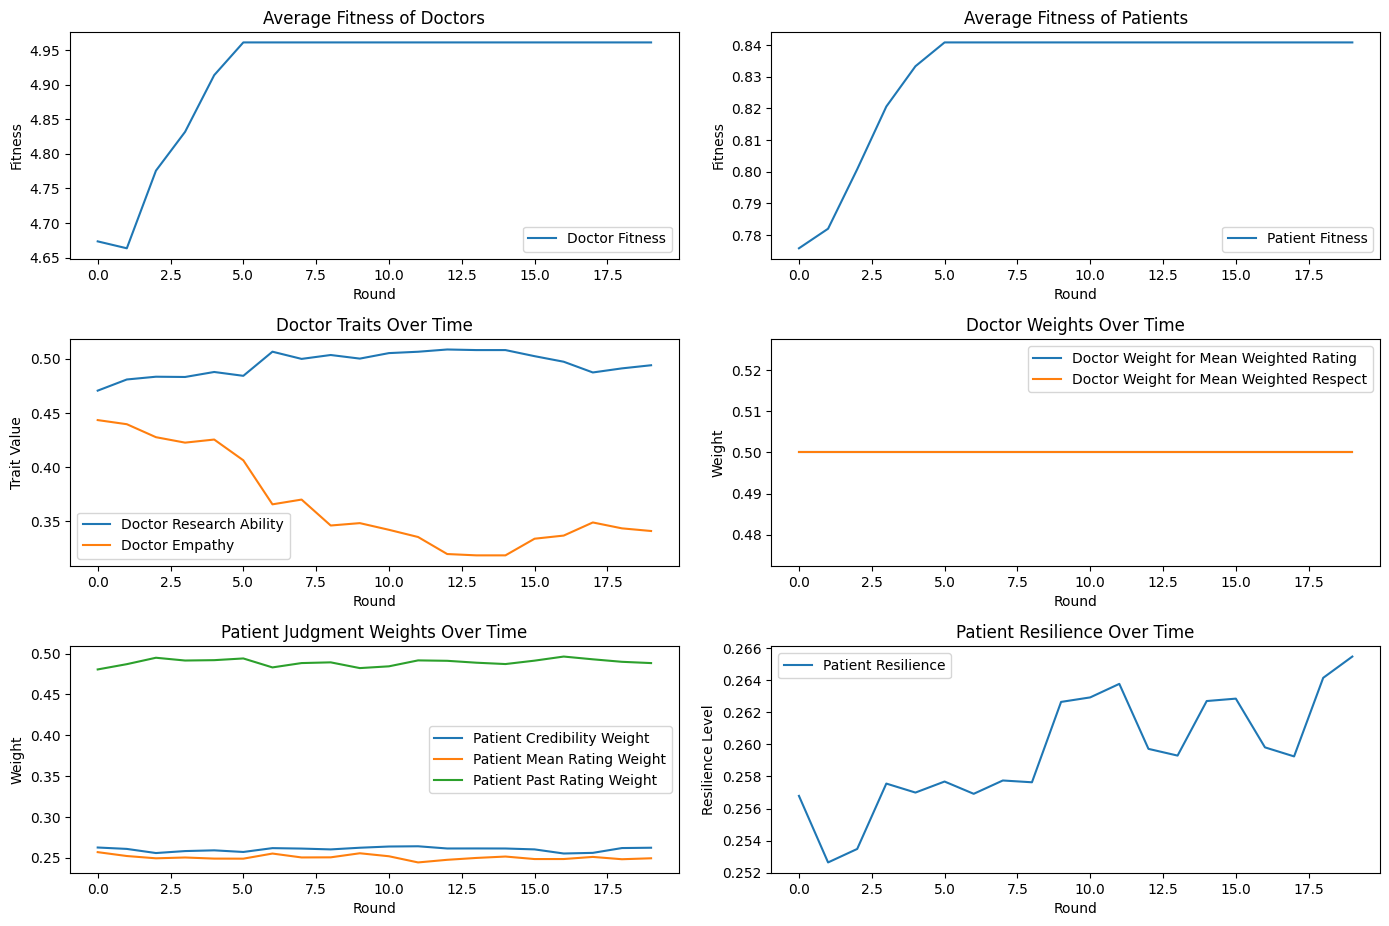

In [8]:
def plot_simulation_results(results):
    # Unpacking results
    doctor_fitness = results["doctor_fitness"]
    patient_fitness = results["patient_fitness"]
    doctor_research_ability = results["doctor_research_ability"]
    doctor_empathy = results["doctor_empathy"]
    doctor_weight_wmrat = results["doctor_weight_wmrat"]
    doctor_weight_mwres = results["doctor_weight_mwres"]
    patient_cred_weight = results["patient_cred_weight"]
    patient_mean_rating_weight = results["patient_mean_rating_weight"]
    patient_past_rating_weight = results["patient_past_rating_weight"]
    patient_resilience = results["patient_resilience"]

    plt.figure(figsize=(14, 12))

    # Plot fitness over time
    plt.subplot(4, 2, 1)
    plt.plot(doctor_fitness, label='Doctor Fitness')
    plt.title('Average Fitness of Doctors')
    plt.xlabel('Round')
    plt.ylabel('Fitness')
    plt.legend()

    plt.subplot(4, 2, 2)
    plt.plot(patient_fitness, label='Patient Fitness')
    plt.title('Average Fitness of Patients')
    plt.xlabel('Round')
    plt.ylabel('Fitness')
    plt.legend()

    # Plot traits for doctors
    plt.subplot(4, 2, 3)
    plt.plot(doctor_research_ability, label='Doctor Research Ability')
    plt.plot(doctor_empathy, label='Doctor Empathy')
    plt.title('Doctor Traits Over Time')
    plt.xlabel('Round')
    plt.ylabel('Trait Value')
    plt.legend()

    plt.subplot(4, 2, 4)
    plt.plot(doctor_weight_wmrat, label='Doctor Weight for Mean Weighted Rating')
    plt.plot(doctor_weight_mwres, label='Doctor Weight for Mean Weighted Respect')
    plt.title('Doctor Weights Over Time')
    plt.xlabel('Round')
    plt.ylabel('Weight')
    plt.legend()

    # Plot traits for patients
    plt.subplot(4, 2, 5)
    plt.plot(patient_cred_weight, label='Patient Credibility Weight')
    plt.plot(patient_mean_rating_weight, label='Patient Mean Rating Weight')
    plt.plot(patient_past_rating_weight, label='Patient Past Rating Weight')
    plt.title('Patient Judgment Weights Over Time')
    plt.xlabel('Round')
    plt.ylabel('Weight')
    plt.legend()

    plt.subplot(4, 2, 6)
    plt.plot(patient_resilience, label='Patient Resilience')
    plt.title('Patient Resilience Over Time')
    plt.xlabel('Round')
    plt.ylabel('Resilience Level')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `results` is defined elsewhere and contains the necessary data
plot_simulation_results(results)


## Multiple

In [9]:
def multiple_simulations(num_doctors, num_patients, num_rounds, num_repetitions=40, seed =None):
    metric_keys = ["doctor_fitness", "patient_fitness", "doctor_research_ability", "doctor_empathy",
                   "doctor_weight_wmrat", "doctor_weight_mwres", "patient_cred_weight", 
                   "patient_mean_rating_weight", "patient_past_rating_weight", "patient_resilience"]
    all_data = {key: [] for key in metric_keys}
    
    final_vals = {} # Store final values for each metric

    for n in range(num_repetitions):
        if seed is not None:
            random.seed(seed + n)  # Ensure different seeds for each repetition
            
        data = run_simulation(num_doctors, num_patients, num_rounds)
        for key in metric_keys:
            all_data[key].append(data[key])

    # Process to calculate mean and std for each metric across repetitions for each round
    means = {}
    std_devs = {}
    for key in metric_keys:
        metric_means = [np.mean(round_data) for round_data in zip(*all_data[key])]
        metric_stds = [np.std(round_data) for round_data in zip(*all_data[key])]
        means[key] = metric_means
        std_devs[key] = metric_stds
        
        final_vals[key] = metric_means[-1]  # Store final value for each metric

    plot_results(means, std_devs, metric_keys)  # Pass metric_keys to plot_results
    
    return final_vals

def plot_results(means, std_devs, metric_keys):
    metrics = ["Doctor Fitness", "Patient Fitness", "Doctor Research Ability", "Doctor Empathy",
               "Doctor Weight for Mean Weighted Rating", "Doctor Weight for Mean Weighted Respect",
               "Patient Credibility Weight", "Patient Mean Rating Weight", "Patient Past Rating Weight",
               "Patient Resilience"]
    rounds = list(range(1, len(next(iter(means.values()))) + 1))
    
    for idx, metric in enumerate(metrics):
        plt.figure(figsize=(10, 6))
        
        # Debug print
        # print(f'STD for {metric}: {std_devs[metric_keys[idx]]}')
        
        plt.errorbar(rounds, means[metric_keys[idx]], yerr=std_devs[metric_keys[idx]],
             label=f'{metric} Avg', fmt='-o', capsize=5)


        plt.fill_between(rounds, 
                         [m - s for m, s in zip(means[metric_keys[idx]], std_devs[metric_keys[idx]])],
                         [m + s for m, s in zip(means[metric_keys[idx]], std_devs[metric_keys[idx]])], 
                         color='gray', alpha=0.2)
        
        plt.title(f'{metric} Over Rounds')
        plt.xlabel('Simulation Round')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

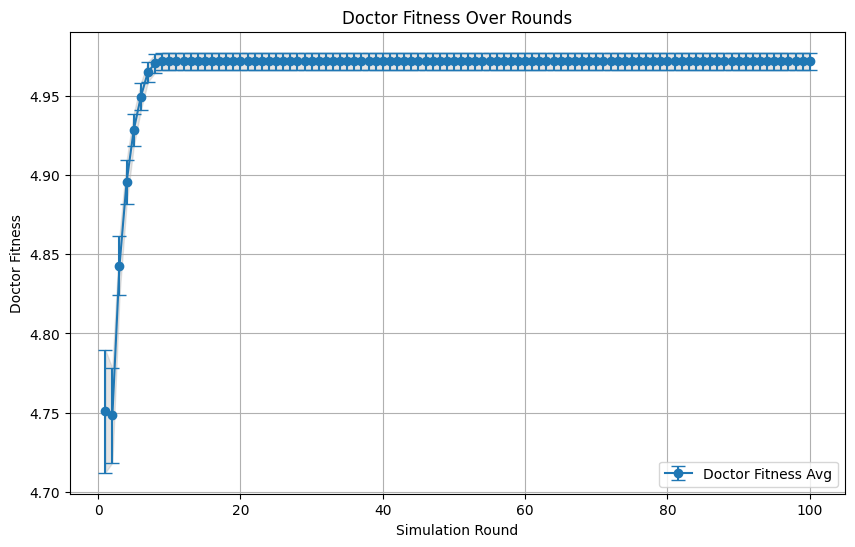

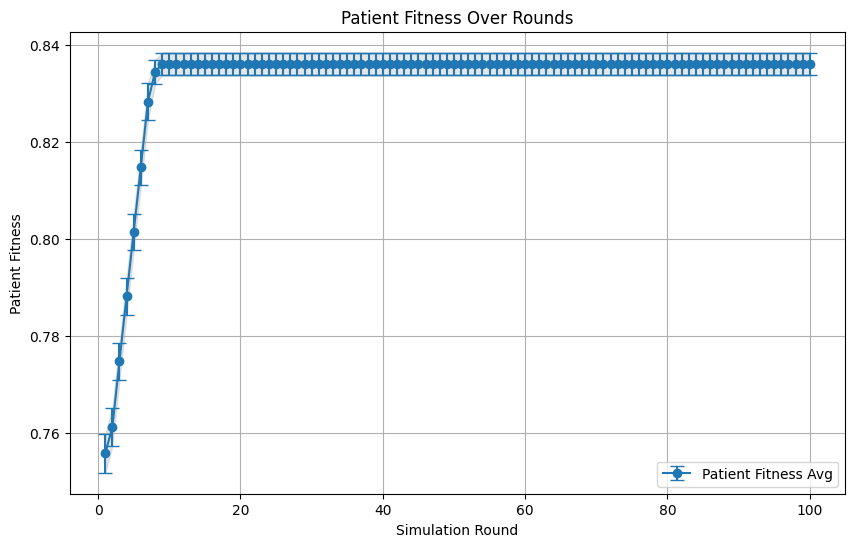

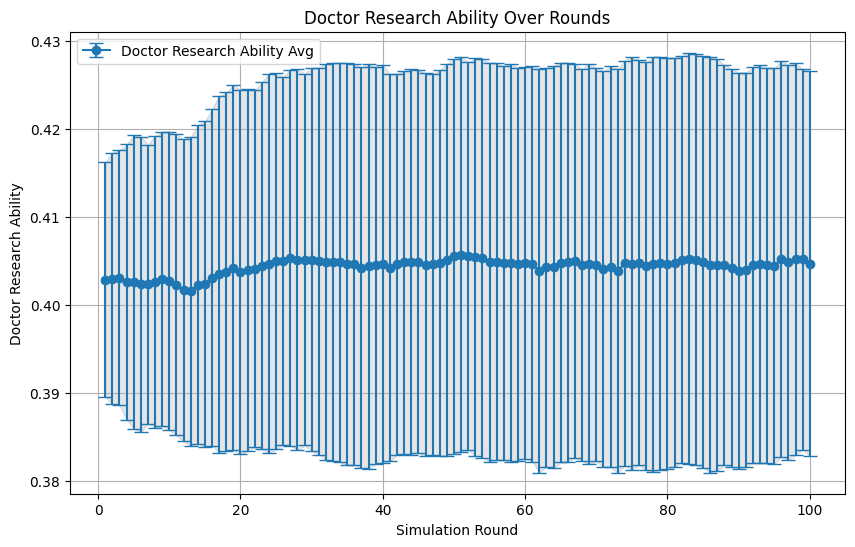

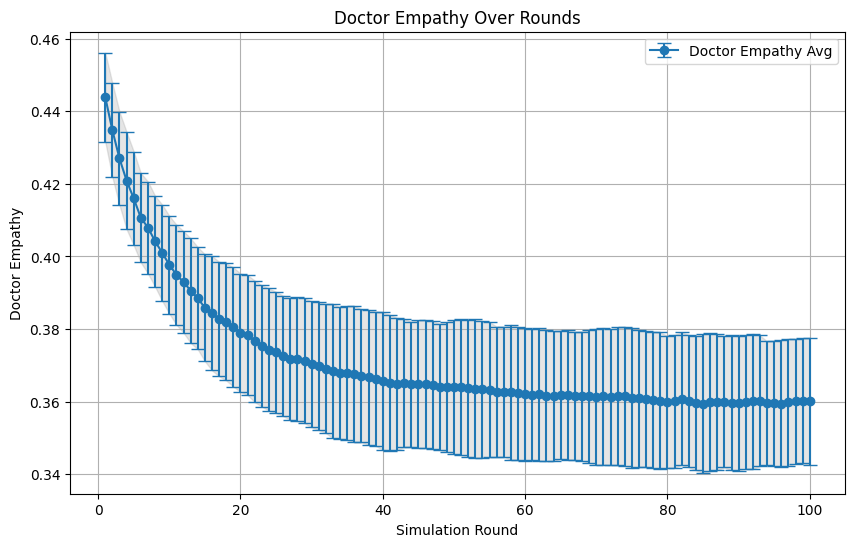

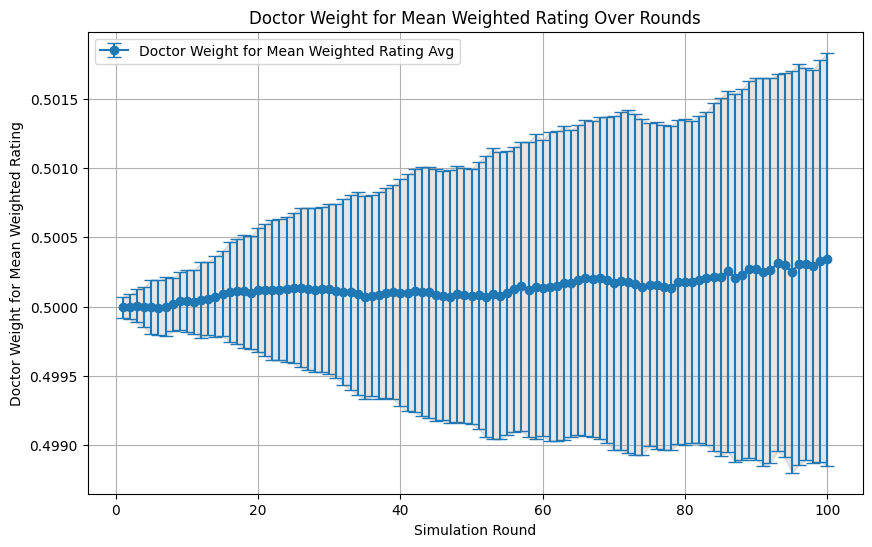

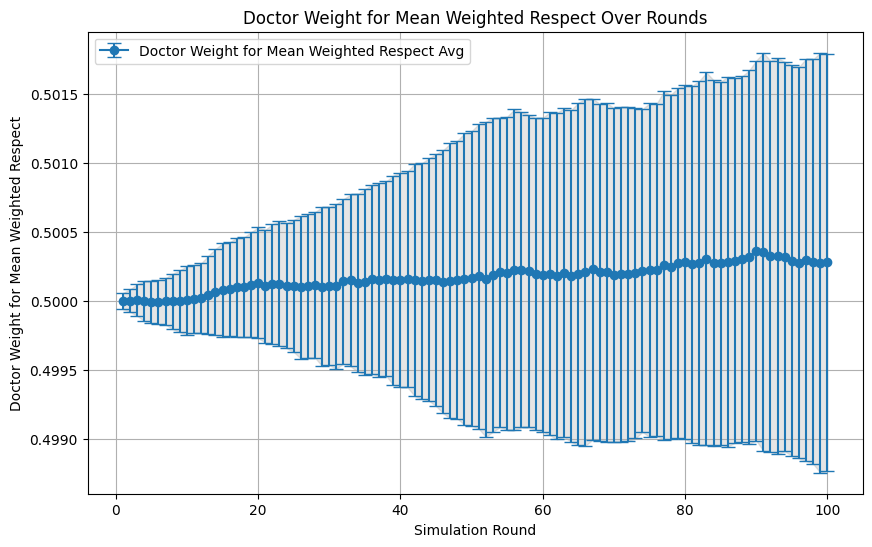

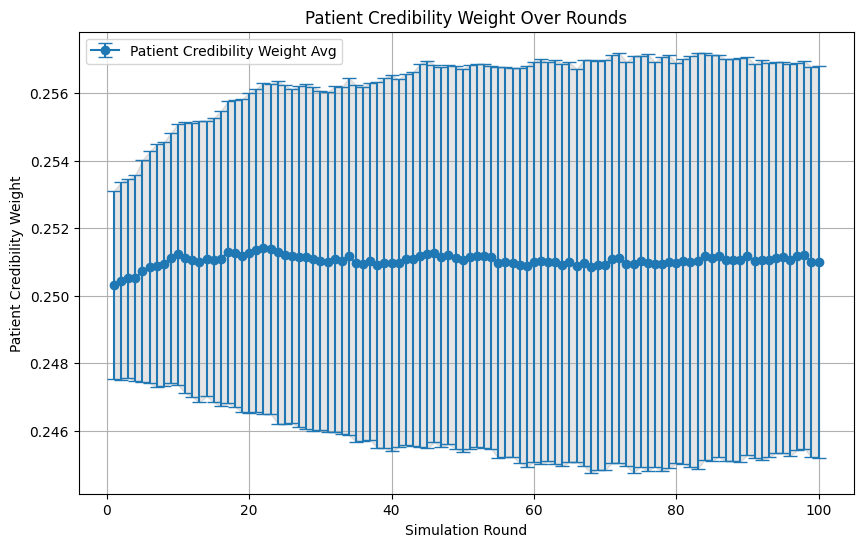

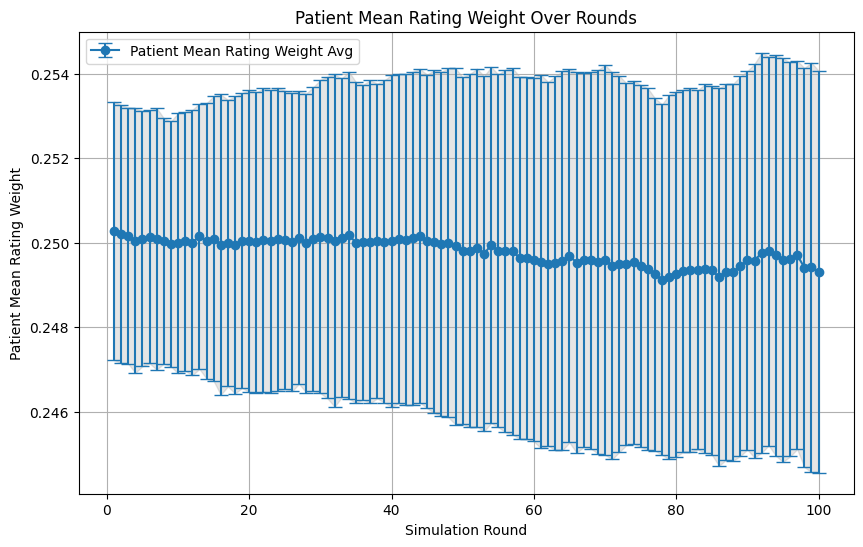

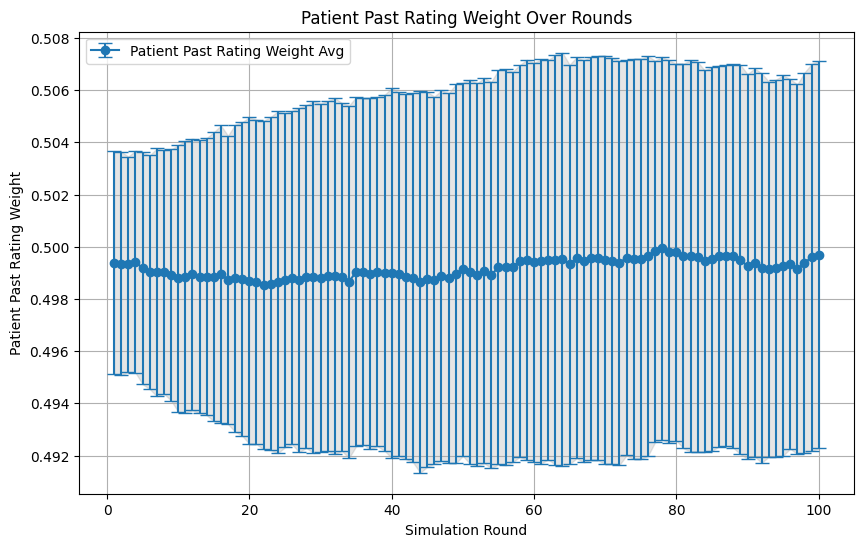

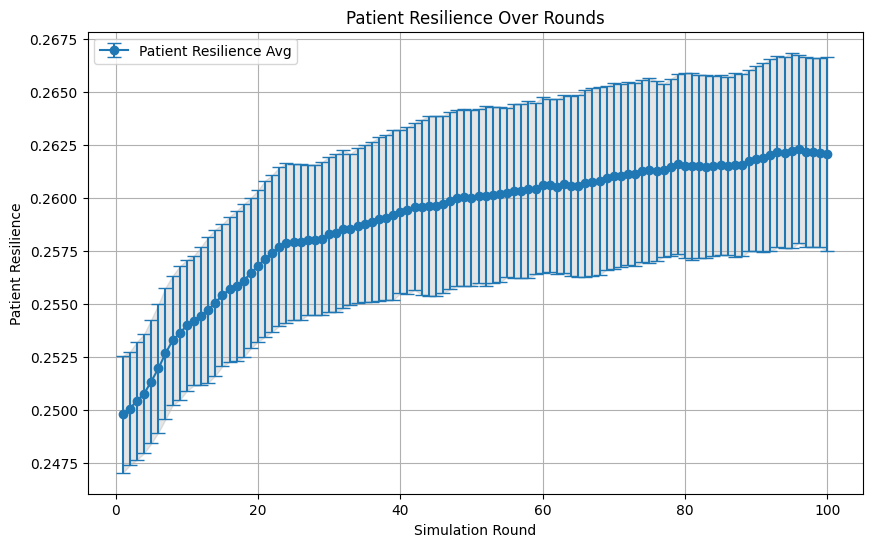

{'doctor_fitness': 4.971549928571427, 'patient_fitness': 0.8360731875604338, 'doctor_research_ability': 0.4046986027676759, 'doctor_empathy': 0.36006006048637795, 'doctor_weight_wmrat': 0.5003412145927846, 'doctor_weight_mwres': 0.500280800129705, 'patient_cred_weight': 0.2509961363381026, 'patient_mean_rating_weight': 0.2493158969719351, 'patient_past_rating_weight': 0.4996910339055913, 'patient_resilience': 0.26207655859618934}


In [10]:
# Run multiple simulations and plot the results
final_metric_vals = multiple_simulations(100, 1000, 100, num_repetitions=50, seed=42)
print(final_metric_vals)  # Print the final values for each metric